In [1]:
import pandas as pd

## Data Understanding

In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [90]:
fake_or_real_df = pd.read_csv('Data/WELFake_Dataset.csv')

In [91]:
fake_or_real_df_1 = fake_or_real_df[['title', 'text', 'label']]

In [92]:
fake_or_real_df_1.loc[fake_or_real_df_1['label'] == 1, 'label'] = "Real"
fake_or_real_df_1.loc[fake_or_real_df_1['label'] == 0, 'label'] = 1

C:\Users\bento\anaconda3.0\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [94]:
fake_or_real_df_1.loc[fake_or_real_df_1['label'] == "Real", 'label'] = 0

C:\Users\bento\anaconda3.0\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [95]:
fake_or_real_df_1

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0
1,NaN,Did they post their votes for Hillary already?,0
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,1
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",0
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,1
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,1


In [59]:
fake_df = pd.read_csv('Data/Fake.csv')
true_df = pd.read_csv('Data/True.csv')

In [61]:
fake_df.drop(columns=['subject', 'date'], inplace=True)
true_df.drop(columns=['subject', 'date'], inplace=True)

fake_df['label'] = 1
true_df['label'] = 0

In [65]:
fake_or_real_df_2 = pd.concat([fake_df, true_df])

In [66]:
fake_or_real_df_2

,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [116]:
fake_or_real_df = pd.concat([fake_or_real_df_1, fake_or_real_df_2])

In [118]:
fake_or_real_df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0
1,NaN,Did they post their votes for Hillary already?,0
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [119]:
fake_or_real_df.drop_duplicates(inplace=True)
fake_or_real_df.dropna(inplace=True)

In [169]:
fake_or_real_df.drop(columns=['title'], inplace=True)

In [170]:
fake_or_real_df

,text,label
0,No comment is expected from Barack Obama Membe...,0
2,"Now, most of the demonstrators gathered last ...",0
3,A dozen politically active pastors came here f...,1
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0
5,All we can say on this one is it s about time ...,0
...,...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [171]:
fake_or_real_df.label.value_counts()

1    52699
0    49527
Name: label, dtype: int64

In [15]:
news_cat = pd.read_json('Data/News_Category_Dataset_v3.json', lines=True)

## Data Preparation

In [152]:
X = fake_or_real_df['text']
y = fake_or_real_df['label']

In [153]:
# intial split of data into traiing and test sets with 15% test size
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=.15, 
                                                        random_state=42)

In [154]:
# second split of data into training and validation sets with 15% val size
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, 
                                                  test_size=0.15,
                                                  random_state=42)

In [155]:
# third split of data into smaller training and val sets
X_train_sub, x1, y_train_sub, y1 = train_test_split(X_train, y_train, 
                                                  test_size=0.5,
                                                  random_state=42)

X_val_sub, x2, y_val_sub, y2 = train_test_split(X_val, y_val, 
                                                test_size=0.5,
                                                random_state=42)

## Data Cleaning

In [173]:
# Transform  data to lowercase
fake_or_real_df['text'] = fake_or_real_df['text'].str.lower()

In [175]:
# Tokenize data
token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(token_pattern)

fake_or_real_df['tokenized'] = fake_or_real_df['text'].apply(tokenizer.tokenize)

In [176]:
fake_or_real_df

,text,label,tokenized
0,no comment is expected from barack obama membe...,0,"[no, comment, is, expected, from, barack, obam..."
2,"now, most of the demonstrators gathered last ...",0,"[now, most, of, the, demonstrators, gathered, ..."
3,a dozen politically active pastors came here f...,1,"[dozen, politically, active, pastors, came, he..."
4,"the rs-28 sarmat missile, dubbed satan 2, will...",0,"[the, rs, 28, sarmat, missile, dubbed, satan, ..."
5,all we can say on this one is it s about time ...,0,"[all, we, can, say, on, this, one, is, it, abo..."
...,...,...,...
21412,brussels (reuters) - nato allies on tuesday we...,0,"[brussels, reuters, nato, allies, on, tuesday,..."
21413,"london (reuters) - lexisnexis, a provider of l...",0,"[london, reuters, lexisnexis, provider, of, le..."
21414,minsk (reuters) - in the shadow of disused sov...,0,"[minsk, reuters, in, the, shadow, of, disused,..."
21415,moscow (reuters) - vatican secretary of state ...,0,"[moscow, reuters, vatican, secretary, of, stat..."


## Exploratory Data Analysis

In [178]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

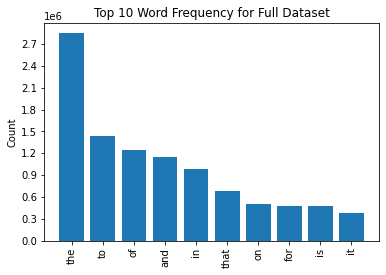

In [180]:
freq_dist = FreqDist(fake_or_real_df['tokenized'].explode())
visualize_top_10(freq_dist, "Top 10 Word Frequency for Full Dataset")

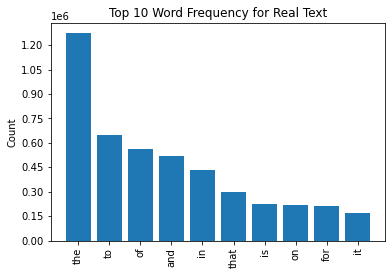

In [182]:
true_freq_dist = FreqDist(fake_or_real_df.loc[fake_or_real_df.label == 0, 'tokenized'].explode())
visualize_top_10(true_freq_dist, "Top 10 Word Frequency for Real Text")

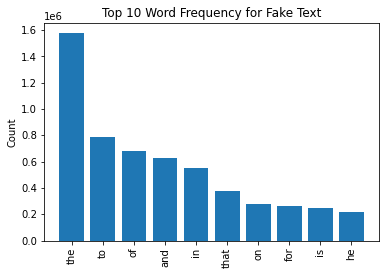

In [181]:
fake_freq_dist = FreqDist(fake_or_real_df.loc[fake_or_real_df.label == 1, 'tokenized'].explode())
visualize_top_10(fake_freq_dist, "Top 10 Word Frequency for Fake Text")

## Modeling

## Final Evaluation

## Conclusion

## Next Steps